# Production Model Sensitivity Analysis

This notebook revisits the simple production model for the purpose of sensitivity analysis. The notebook uses [Pyomo](http://www.pyomo.org/) to represent the model with the [COINOR-CBC](https://github.com/coin-or/Cbc) solver to calculate solutions.

## Imports

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc 
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))

from pyomo.environ import *

## Production plan: Mixed product strategy

So far we have learned that we can make \$1,600 per week by manufacturing product X, and $2,400 per week manufacturing product Y.  Is it possible to do even better?

To answer this question, we consider the possibilty of manufacturing both products in the same plant. The marketing department assures us that product Y will not affect the sales of product X.  So the same constraints hold as before, but now we have two decision variables, $x$ and $y$.

![LP_ProductXY.png](https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/figures/LP_ProductXY.png?raw=1)

In [68]:
model = ConcreteModel()

# declare decision variables
model.x = Var(domain=NonNegativeReals)
model.y = Var(domain=NonNegativeReals)

# declare objective
model.profit = Objective(
    expr = 40*model.x + 30*model.y,
    sense = maximize)

# declare constraints
model.demand = Constraint(expr = model.x <= 40)
model.laborA = Constraint(expr = model.x + model.y <= 80)
model.laborB = Constraint(expr = 2*model.x + model.y <= 100)

# solve
SolverFactory('cbc').solve(model)

print(f"P = {model.profit()}")
print(f"x = {model.x()}")
print(f"y = {model.y()}")

P = 2600.0
x = 20.0
y = 60.0


The mixed product strategy earns more profit than either of the single product srategies. Does this surprise you?  Before going further, try to explain why it is possible for a mixed product strategy to earn more profit than either of the possible single product strategies.

## What are the active constraints?

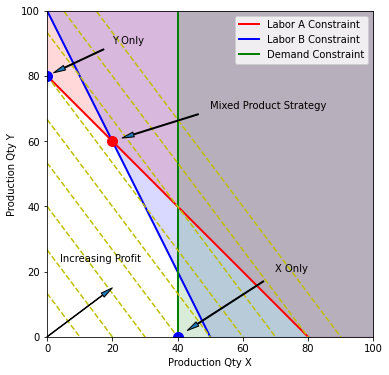

In [69]:
plt.figure(figsize=(6, 6))
plt.subplot(111, aspect='equal')
plt.axis([0, 100, 0, 100])
plt.xlabel('Production Qty X')
plt.ylabel('Production Qty Y')

# Labor A constraint
x = np.array([0, 80])
y = 80 - x
plt.plot(x, y, 'r', lw=2)
plt.fill_between([0, 80, 100], [80, 0,0 ], [100, 100, 100], color='r', alpha=0.15)

# Labor B constraint
x = np.array([0, 50])
y = 100 - 2*x
plt.plot(x, y, 'b', lw=2)
plt.fill_between([0, 50, 100], [100, 0, 0], [100, 100, 100], color='b', alpha=0.15)

# Demand constraint
plt.plot([40, 40], [0, 100], 'g', lw=2)
plt.fill_between([40, 100], [0, 0], [100, 100], color='g', alpha=0.15)

plt.legend(['Labor A Constraint', 'Labor B Constraint', 'Demand Constraint'])

# Contours of constant profit
x = np.array([0, 100])
for p in np.linspace(0, 3600, 10):
    y = (p - 40*x)/30
    plt.plot(x, y, 'y--')

# Optimum
plt.plot(20, 60, 'r.', ms=20)
plt.annotate('Mixed Product Strategy', xy=(20, 60), xytext=(50, 70), 
             arrowprops=dict(shrink=.1, width=1, headwidth=5))

plt.plot(0, 80, 'b.', ms=20)
plt.annotate('Y Only', xy=(0, 80), xytext=(20, 90), 
             arrowprops=dict(shrink=0.1, width=1, headwidth=5))

plt.plot(40, 0, 'b.', ms=20)
plt.annotate('X Only', xy=(40, 0), xytext=(70, 20), 
             arrowprops=dict(shrink=0.1, width=1, headwidth=5))

plt.text(4, 23, 'Increasing Profit')
plt.annotate('', xy=(20,15), xytext=(0,0), 
             arrowprops=dict(width=0.5,headwidth=5))

fname = 'LPprog01.png'
fname = os.path.join('figures', fname) if os.path.exists('figures') else fname
plt.savefig(fname, bbox_inches='tight')

## Sensitivity analysis

Sensitivity analysis is the process of determining how the solution to a linear programming problem (or for that matter, any optimization problem) depends on parameter values. This can lead to important insights. In this toy application, for example, sensitivity analysis will reveal the extra profit obtained by adding additional hours of labor. For many applications, the information obtained from sensitivity analysis can be the primary reason to create the linear program.

For the general case, assume that the linear program can be written in the form

$$
\begin{align*}
P = \max c^Tx \\
\end{align*}
$$
subject to
$$
\begin{align*}
A x \leq b \\
x \geq 0 
\end{align*}
$$

The inequality constraints can be combined into a single matrix expression

$$
\begin{align*}
\begin{bmatrix} A \\ -I \end{bmatrix} x \leq \begin{bmatrix} b \\ 0 \end{bmatrix}
\end{align*}
$$

A general feature of linear programming problems with $n$ decision variables is that the optimal value of the objective is found at the intersection of $n$ active constraints. At the optimal solution, the active constraints can be treated as linear equalities. Let the matrix $A_a$ refer to the subset of $n$ rows of $\begin{bmatrix} A \\ -I \end{bmatrix}$ comprising the active constraints, and $b_a$ be the corresponding elements of $b$. The solution to the linear program is then given by 

$$
\begin{align*}
P & = c^T x \\
A_ax & = b_a
\end{align*}
$$

Solving for $x {A_a}^{-1}b_a$

$$
\begin{align*}
P & = c^T {A_a}^{-1} b_a 
\end{align*}
$$

The quantities in the vector $c^T {A_a}^{-1}$ show how the profit $P$ depends on small changes in the available resources given in $b_a$.

$$
\begin{align*}
P + \delta P  = c^T {A_a}^{-1} (b_a + \delta b_a) \implies \delta P  = \underbrace{c^T {A_a}^{-1}}_{y^T} \delta b_a
\end{align*}
$$

The vector $y^T = c^T {A_a}^{-1}$ are the sensitivity coefficients. 

Let's see how this works out for the toy problem in this notebook. First we define the 'augmented' matrices corresponding to the inequality constraints.

In [70]:
A_augment = np.array([[1, 0], [1, 1], [2, 1], [-1, 0], [0, -1]])
b_augment = np.array([[40], [80], [100], [0], [0]])
c = np.array([40, 30])

print(f"\nA = {A_augment}")
print(f"\nb = {b_augment}")
print(f"\nc = {c}")


A = [[ 1  0]
 [ 1  1]
 [ 2  1]
 [-1  0]
 [ 0 -1]]

b = [[ 40]
 [ 80]
 [100]
 [  0]
 [  0]]

c = [40 30]


The active constraints are rows 2 and 3 that correspond to the labor constraints. Since Python uses zero-indexing, 

In [45]:
active_constraints = [1, 2]

A_active = A_augment[active_constraints, :]
b_active = b_augment[active_constraints, :]

Next let's verify that we are getting the expected solution.

In [71]:
x = np.dot(np.linalg.inv(A_active), b_active)
print(f"\nx = {x}")

P = np.dot(c, x)
print(f"\nP = {P}")


x = [[20.]
 [60.]]

P = [2600.]


Now compute the sensitivity coefficients.

In [47]:
y = np.dot(c, np.linalg.inv(A_active))
print(f"\ny = {y}")


y = [20. 10.]


These coefficients describe the incremental profit that can be obtained for each additional unit of the corresponding resource in $b_a$.

## Adjoint sensitivity

The sensitivity coefficients can be computed as

$$
\begin{align*}
y^T = c^T {A_a}^{-1}
\end{align*}
$$

which involves inversion of a linear matrix. This is an expensive and potentially sensitive numerical operation which can be avoided.  

$$
\begin{align*}
y^T = c^T {A_a}^{-1} \implies y^T A_a = c^T \implies A_a^T y = c
\end{align*}
$$

In other words, $y$ can be computed by solving a system of equations involving the transposed matrix $A_a^T$ with the coefficients of the objective function on the right hand side.

In [49]:
np.linalg.solve(A_active.T, c)

array([20., 10.])

## Accessing sensitivity coefficients in Pyomo

In [72]:
model = ConcreteModel()

# for access to dual solution for constraints
model.dual = Suffix(direction=Suffix.IMPORT)

# declare decision variables
model.x = Var(domain=NonNegativeReals)
model.y = Var(domain=NonNegativeReals)

# declare objective
model.profit = Objective(
    expr = 40*model.x + 30*model.y,
    sense = maximize)

# declare constraints
model.demand = Constraint(expr = model.x <= 40)
model.laborA = Constraint(expr = model.x + model.y <= 80)
model.laborB = Constraint(expr = 2*model.x + model.y <= 100)

# solve
SolverFactory('cbc').solve(model)

print("\nSolution")
print(f"x = {model.x()}")
print(f"y = {model.y()}")

print("\nSensitivity Analysis")
print(f"y_demand = {-model.dual[model.demand]}")
print(f"y_laborA = {-model.dual[model.laborA]}")
print(f"y_laborB = {-model.dual[model.laborB]}")


Solution
x = 20.0
y = 60.0

Sensitivity Analysis
y_demand = -0.0
y_laborA = 20.0
y_laborB = 10.0


Analysis of the constraints.

In [10]:
str = "   {0:7.2f} {1:7.2f} {2:7.2f} {3:7.2f}"

print("Constraint  value  lslack  uslack    dual")
for c in [model.demand, model.laborA, model.laborB]:
    print(c, str.format(c(), c.lslack(), c.uslack(), model.dual[c]))

Constraint  value  lslack  uslack    dual
demand      20.00     inf   20.00    0.00
laborA      80.00     inf    0.00  -20.00
laborB     100.00     inf    0.00  -10.00


## Theory of constraints

* For $n$ decisions you should expect to find $n$ 'active' constraints.
* Each inactive constraint has an associated 'slack.'  The associated resources have no incremental value.
* Each active constraint has an associated 'shadow price'.  This is additional value of additional resources.